<a href="https://colab.research.google.com/github/jeffheaton/app_deep_learning/blob/main/t81_558_class_09_1_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# T81-558: Applications of Deep Neural Networks

**Module 9: Facial Recognition**

- Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
- For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).


# Module 9 Material

- **Part 9.1: Detecting Faces in an Image** [[Video]](https://www.youtube.com/watch?v=Hpp3D3P2iWQ&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_09_1_faces.ipynb)
- Part 9.2: Detecting Facial Features [[Video]](https://www.youtube.com/watch?v=AblTbq0T2wE&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_09_2_face_features.ipynb)
- Part 9.3: Reality Augmentation [[Video]](https://www.youtube.com/watch?v=jfZDiRxx5Bc&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_09_3_reality_augmentation.ipynb)
- Part 9.4: Application: Emotion Detection [[Video]](https://www.youtube.com/watch?v=F0H6vojQhE8&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_09_4_emotion.ipynb)
- Part 9.5: Application: Blink Efficiency [[Video]](https://www.youtube.com/watch?v=96LPEStHCUA&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_09_5_blink.ipynb)


# Google CoLab Instructions

The following code checks that Google CoLab is and sets up the correct hardware settings for PyTorch.


In [ ]:
try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
import torch

device = (
    "mps"
    if getattr(torch, "has_mps", False)
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Note: using Google CoLab
Using device: cuda


# Part 9.1: Detecting Faces in an Image

In the realm of computer vision, the ability to identify and interpret human faces is a cornerstone application. Our innate human ability to recognize and understand facial structures translates to a computational challenge when implemented in machines. The foundation of this task is twofold: firstly, the detection of faces in images, and secondly, the identification of facial landmarks on these detected faces.

Facial landmarks refer to specific key points on a human face that hold significance. These can be corners of the eyes, the tip of the nose, contours of the lips, and so on. Recognizing these landmarks allows computers to understand facial expressions, conduct morphological studies, assist in digital makeup or facial recognition tasks, and much more. Essentially, these landmarks provide a structured map of the face, enabling various applications to thrive.

However, before a machine can pinpoint these landmarks, it must be able to recognize a face within an image. It's akin to needing to find a canvas before painting on it. Detecting faces in an image is the precursor to identifying the detailed features or landmarks on it.

For the purpose of this chapter, we will be utilizing the **facenet-pytorch** library. facenet-pytorch is a powerful Python library specifically tailored for face detection and facial landmark identification, leveraging the capabilities of the FaceNet architecture with the efficiency of the PyTorch framework. Whether you're a beginner in computer vision or an advanced practitioner, this library offers an efficient and convenient approach to face-related tasks.

To kickstart our journey, let's begin by installing the necessary library. The following code will install facenet-pytorch:


In [ ]:
!pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.0 MB/s eta 0:00:00


Before discussing the mechanics of face detection and landmark identification, it's crucial to understand the initial step: loading an image. Many of the sophisticated operations in computer vision are dependent on this basic but fundamental task.

For our exercises, we will be utilizing the **requests** package. This is a popular Python library employed for making HTTP requests, which can be used to fetch images directly from the web. By doing this, we can work with a myriad of images without the need to manually download and store them on our local machine.

Once we have fetched the image, it's important to note that **facenet-pytorch** operates on images in a specific format provided by the Python Imaging Library (PIL). The PIL, often accessed via its Pillow fork, offers extensive capabilities for opening, manipulating, and saving various image file formats. This is because **facenet-pytorch** specifically accepts PIL-formatted images, as this format provides a standard and efficient representation suitable for further processing.

Thus, after retrieving an image with the requests package, we'll convert it into a PIL Image. This ensures that it's in the right format for subsequent face detection and landmark identification tasks.

In [ ]:
import torch
from facenet_pytorch import MTCNN
from PIL import Image
import requests
from io import BytesIO
import torch
from PIL import Image, ImageDraw

# Load image
#url = "https://data.heatonresearch.com/images/wustl/data/AdobeStock_319245189-low.jpg"
url = "https://data.heatonresearch.com/images/wustl/data/img1-512.jpg"
response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
img = Image.open(BytesIO(response.content))
img.load()

We will apply the MTCNN model, a cornerstone from the pytorch-facenet repository. The Multi-task Cascaded Convolutional Networks (MTCNN) is a specialized framework that has been designed primarily for face detection, alignment, and cropping. Its unique approach is founded on a three-tiered hierarchy, each employing convolutional networks that execute their tasks sequentially. We will briefly review these internal details. The initial stage, known as the P-Net, generates potential face candidates using a fully convolutional methodology, also producing bounding box regression vectors for further refinement. Following this, the R-Net takes center stage, taking it upon itself to sift out a multitude of false positives from the initial proposals, while continuing the task of bounding box correction. Culminating this intricate process is the O-Net, which takes on a dual role. Not only does it further refine the bounding boxes, but it also generates vital facial landmarks.  

With the MTCNN model in our arsenal, we can seamlessly process images to extract all discernible faces. This extraction process is straightforward: the image is fed into the MTCNN model, traverses through the cascading three-stage pipeline, and finally outputs the bounding boxes of detected faces, optionally paired with their respective facial landmarks.

However, as with any sophisticated model, MTCNN is not without its imperfections. It's crucial to understand that we might be faced with 'false hits'. Specifically, there's the potential for False Positives, where regions not containing faces are mistakenly identified as such. Conversely, False Negatives represent genuine facial regions that the model unfortunately overlooks. To aid in navigating these detections, MTCNN typically offers detections ranked by a confidence score. This hierarchy implies that the first images or bounding boxes in your list are those that the model holds in the highest confidence as faces. As you traverse further down the list, this confidence invariably wanes, making the initial images the most likely candidates for genuine faces.

We begin with this code that initializes the MTCNN face detection model, ensuring that it retains all detected faces and assigns it to the appropriate computing device. Upon feeding the image (img) to the MTCNN model, it detects potential face regions and returns their bounding boxes. The program then prepares the image for annotation by establishing a drawing context. For each detected face, the code delineates the bounding box with a red rectangle and subsequently prints the coordinates of that box. Alongside the printed coordinates, a textual description detailing the location of each face's bounding box is also provided. Finally, the image, now annotated with the detected faces' bounding boxes, is displayed to the user.



[165.3406982421875 67.05964660644531 367.87255859375 338.9952087402344]
Found a face at the bounding box, Left: 165.3406982421875, Top: 67.05964660644531, Right: 367.87255859375, Bottom: 338.9952087402344


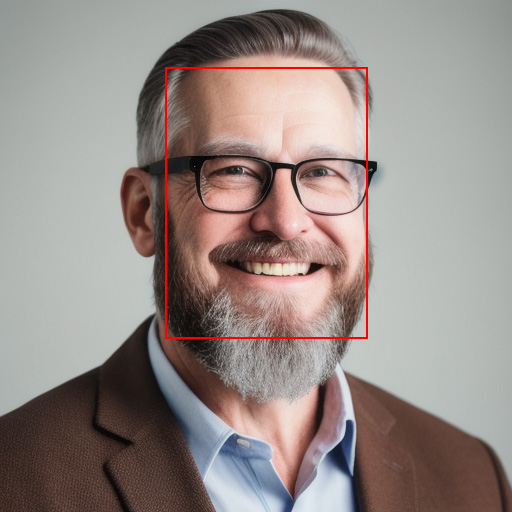

In [ ]:
mtcnn = MTCNN(keep_all=True, device=device)

# Detect faces
boxes, _ = mtcnn.detect(img)

# Prepare to draw on the image
draw = ImageDraw.Draw(img)

# Draw bounding boxes
for box in boxes:
    draw.rectangle(box.tolist(), outline="red", width=2)
    print(box)
    print(f"Found a face at the bounding box, Left: {box[0]}, Top: {box[1]}, Right: {box[2]}, Bottom: {box[3]}")
display(img)

# Detecting Multiple Faces

Detecting multiple faces within an image is often crucial in various applications, from surveillance to group photo enhancements and beyond. The MTCNN, with its robust and precise face detection capabilities, is adept at identifying multiple faces in a single frame, regardless of variances in size, orientation, or facial features. In many scenarios, like group photos or crowded spaces, an image contains several faces. Being able to process each individual face separately can be valuable. For instance, in facial recognition systems, you would want to identify every individual in a group image. Or, in photo editing applications, you might aim to enhance or apply filters to each face distinctly. By utilizing MTCNN, one can detect, extract, and subsequently process each detected face, ensuring that every individual within an image receives the desired attention or processing.

Lets see what we can do with the following image.

![Multiple Faces](https://data.heatonresearch.com/images/wustl/data/AdobeStock_319245189.jpeg)

In our pursuit to process a high-resolution image containing several faces, we aim to not only detect each face but also to crop and extract them for individualized processing. The provided code begins by iterating through each detected face, denoted by its bounding box. For every face, it provides a summary of its location in terms of left, top, right, and bottom coordinates. Subsequent to identification, each face is cropped from the main image. To ensure uniformity in further processing, the cropped face is resized, maintaining its original aspect ratio. This is achieved by standardizing the width to 128 pixels and adjusting the height proportionally. The resizing utilizes the LANCZOS filter, known for its high-quality resampling. While the code has a provision to save each resized face as a JPEG image, this option is currently commented out. Instead, after each resize operation, the individual face is displayed to the user, allowing for a visual confirmation of the extraction process.

Found a face at the bounding box, Left: 1881.234619140625, Top: 938.9395751953125, Right: 2422.770263671875, Bottom: 1668.334716796875


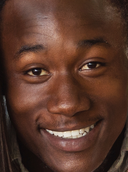

Found a face at the bounding box, Left: 2565.966064453125, Top: 752.9630737304688, Right: 3097.4775390625, Bottom: 1486.925048828125


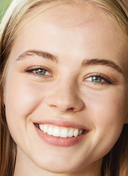

Found a face at the bounding box, Left: 3408.988525390625, Top: 1115.6810302734375, Right: 3969.9716796875, Bottom: 1778.73779296875


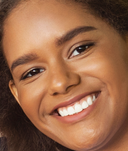

Found a face at the bounding box, Left: 3151.56494140625, Top: 324.6169128417969, Right: 3682.420166015625, Bottom: 998.4337158203125


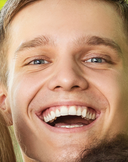

Found a face at the bounding box, Left: 1246.0784912109375, Top: 899.0545654296875, Right: 1734.765625, Bottom: 1580.8331298828125


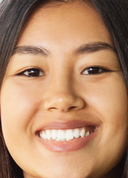

In [ ]:
# Load image
url = "https://data.heatonresearch.com/images/wustl/data/AdobeStock_319245189.jpeg"

response = requests.get(url,headers={'User-Agent': 'Mozilla/5.0'})
img = Image.open(BytesIO(response.content))
img.load()

# Detect faces
boxes, _ = mtcnn.detect(img)

# Draw bounding boxes
for index, box in enumerate(boxes):
  print(f"Found a face at the bounding box, Left: {box[0]}, Top: {box[1]}, Right: {box[2]}, Bottom: {box[3]}")
  # Crop face
  cropped_face = img.crop(box.tolist())

  # Determine new height based on aspect ratio, with width standardized to 128 pixels
  aspect_ratio = cropped_face.height / cropped_face.width
  new_height = int(128 * aspect_ratio)

  # Resize the cropped image to maintain aspect ratio
  resized_face = cropped_face.resize((128, new_height), Image.LANCZOS)

  # Save the resized image as JPEG
  #resized_face.save(f"face_{index + 1}.jpeg", "JPEG")

  display(resized_face)



Detecting faces in an image is a foundational step, but it's just the tip of the iceberg when it comes to facial processing. In our subsequent section, we delve deeper by detecting facial landmarks within the individual faces we've extracted. Facial landmarks are specific points on a face, typically identified at key regions like the eyes, nose, mouth, and jawline.

# Module 9 Assignment

You can find the nineth assignment here: [assignment 9](https://github.com/jeffheaton/app_deep_learning/blob/main/assignments/assignment_yourname_class9.ipynb)
